In [1]:


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report

import shap
from mlxtend.frequent_patterns import apriori, fpgrowth, association_rules

import warnings
warnings.filterwarnings("ignore")

sns.set(style="whitegrid")

# Для визуализации красивых графиков
sns.set(style="whitegrid")

df = pd.read_csv("sensor_readings_24.data", sep=",", header=None)

In [2]:
print("Размер данных:", df.shape)
print("\nПервые 5 строк:\n", df.head())
print("\nТипы данных:\n", df.dtypes)
print("\nПроверка пропусков:\n", df.isnull().sum())

Размер данных: (5456, 25)

Первые 5 строк:
       0      1      2      3    4      5    6      7      8      9   ...  \
0  0.438  0.498  3.625  3.645  5.0  2.918  5.0  2.351  2.332  2.643  ...   
1  0.438  0.498  3.625  3.648  5.0  2.918  5.0  2.637  2.332  2.649  ...   
2  0.438  0.498  3.625  3.629  5.0  2.918  5.0  2.637  2.334  2.643  ...   
3  0.437  0.501  3.625  3.626  5.0  2.918  5.0  2.353  2.334  2.642  ...   
4  0.438  0.498  3.626  3.629  5.0  2.918  5.0  2.640  2.334  2.639  ...   

      15     16     17     18     19     20     21     22     23  \
0  0.593  0.502  0.493  0.504  0.445  0.431  0.444  0.440  0.429   
1  0.592  0.502  0.493  0.504  0.449  0.431  0.444  0.443  0.429   
2  0.593  0.502  0.493  0.504  0.449  0.431  0.444  0.446  0.429   
3  0.593  0.502  0.493  0.504  0.449  0.431  0.444  0.444  0.429   
4  0.592  0.502  0.493  0.504  0.449  0.431  0.444  0.441  0.429   

                  24  
0  Slight-Right-Turn  
1  Slight-Right-Turn  
2  Slight-Right-Turn 

In [3]:
X = df.iloc[:, :-1]  # 24 сенсора
y = df.iloc[:, -1]   # метка движения (строка)

# Кодируем метки в числа для классификации
le = LabelEncoder()
y_encoded = le.fit_transform(y)
print("\nКлассы:", le.classes_)


Классы: ['Move-Forward' 'Sharp-Right-Turn' 'Slight-Left-Turn' 'Slight-Right-Turn']


In [4]:
#standard 

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled, columns=X.columns)

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded
)


In [6]:
classifiers = {
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Random Forest": RandomForestClassifier(n_estimators=200, random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(n_estimators=200, random_state=42),
    "SVM": SVC(probability=True, kernel='rbf', random_state=42)
}

In [7]:
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

results = []

for name, clf in classifiers.items():
    f1_scores = []
    roc_scores = []
    
    for train_index, val_index in skf.split(X_train, y_train):
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = y_train[train_index], y_train[val_index]
        
        clf.fit(X_tr, y_tr)
        y_pred = clf.predict(X_val)
        y_prob = clf.predict_proba(X_val)
        
        f1_scores.append(f1_score(y_val, y_pred, average='weighted'))
        
        # ROC-AUC для многоклассовых задач
        try:
            roc_scores.append(roc_auc_score(y_val, y_prob, multi_class='ovr'))
        except:
            roc_scores.append(np.nan)
    
    results.append({
        "Classifier": name,
        "F1_mean": np.mean(f1_scores),
        "F1_std": np.std(f1_scores),
        "ROC_mean": np.nanmean(roc_scores),
        "ROC_std": np.nanstd(roc_scores)
    })

results_df = pd.DataFrame(results)
print("\nСравнение классификаторов:\n", results_df)


Сравнение классификаторов:
             Classifier   F1_mean    F1_std  ROC_mean   ROC_std
0  Logistic Regression  0.701296  0.006835  0.905666  0.003839
1        Random Forest  0.991727  0.001865  0.999807  0.000158
2    Gradient Boosting  0.995859  0.001882  0.999986  0.000018
3                  SVM  0.870958  0.019052  0.976507  0.003430


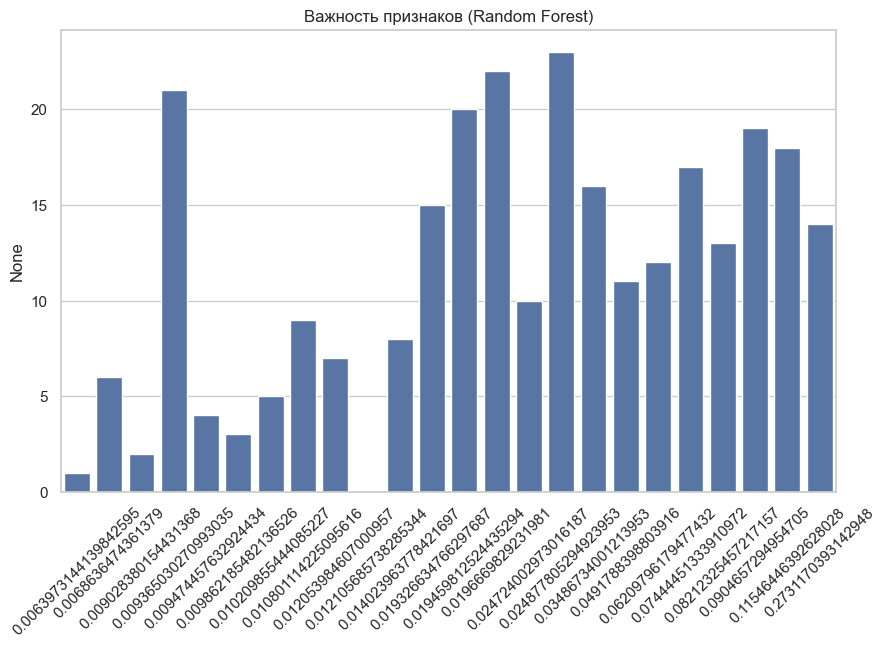

In [15]:
rf = RandomForestClassifier(n_estimators=500, random_state=42)
rf.fit(X_train, y_train)

importances = rf.feature_importances_
feat_importances = pd.Series(importances, index=X.columns).sort_values(ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(x=feat_importances.values, y=feat_importances.index)
plt.title("Важность признаков (Random Forest)")
plt.xticks(rotation=45) # Повернет подписи на 45 градусов
plt.show()

<class 'shap._explanation.Explanation'>
(4364, 24, 4)


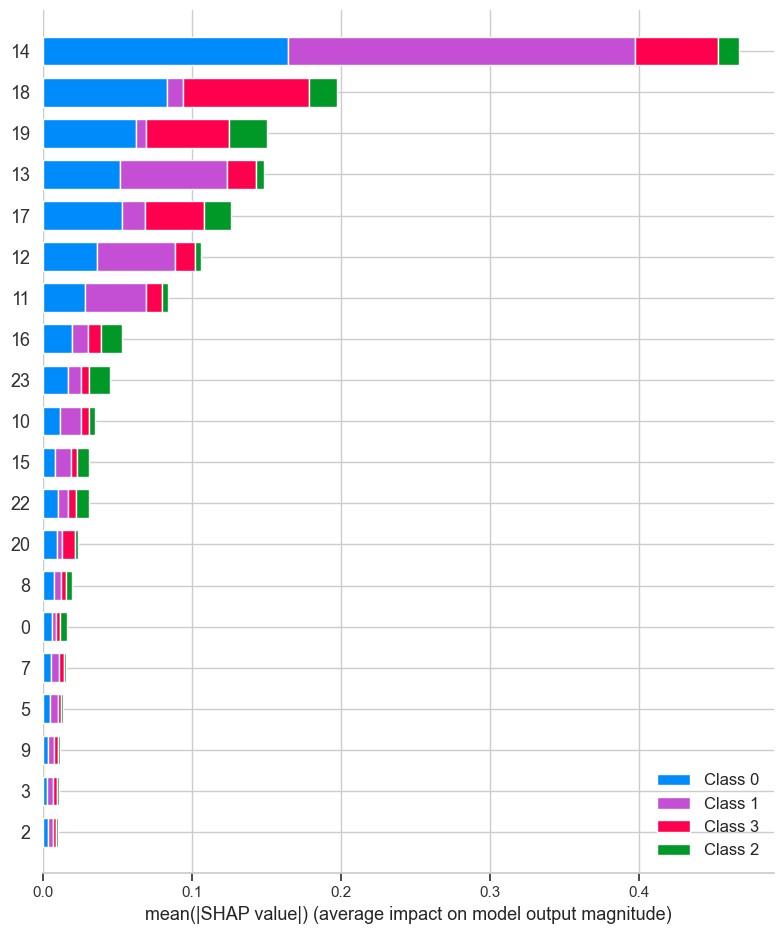

In [12]:
explainer = shap.TreeExplainer(rf)
shap_values = explainer(X_train)

print(type(shap_values))
# Если это массив numpy, проверьте его форму:
if hasattr(shap_values, 'shape'):
    print(shap_values.shape)

# Для первого класса
shap.summary_plot(shap_values, X_train)

In [13]:
#10. Ассоциативный анализ
# -------------------------------
# Переведем числовые сенсоры в бинарные признаки по квантилям
X_bin = X.apply(lambda col: col > col.median(), axis=0)
X_bin = X_bin.astype(int)

# Apriori
frequent_itemsets_ap = apriori(X_bin, min_support=0.3, use_colnames=True)
rules_ap = association_rules(frequent_itemsets_ap, metric="lift", min_threshold=1.0)
print("\nApriori правила (топ-5 по lift):\n", rules_ap.sort_values("lift", ascending=False).head())

# FP-Growth
frequent_itemsets_fp = fpgrowth(X_bin, min_support=0.3, use_colnames=True)
rules_fp = association_rules(frequent_itemsets_fp, metric="lift", min_threshold=1.0)
print("\nFP-Growth правила (топ-5 по lift):\n", rules_fp.sort_values("lift", ascending=False).head())


Apriori правила (топ-5 по lift):
              antecedents          consequents  antecedent support  \
164      frozenset({17})  frozenset({16, 18})            0.498900   
161  frozenset({16, 18})      frozenset({17})            0.368768   
167  frozenset({16, 19})      frozenset({17})            0.323130   
170      frozenset({17})  frozenset({16, 19})            0.498900   
179  frozenset({17, 19})      frozenset({18})            0.389113   

     consequent support   support  confidence      lift  representativity  \
164            0.368768  0.358138    0.717855  1.946627               1.0   
161            0.498900  0.358138    0.971173  1.946627               1.0   
167            0.498900  0.311950    0.965400  1.935056               1.0   
170            0.323130  0.311950    0.625276  1.935056               1.0   
179            0.499450  0.374267    0.961846  1.925811               1.0   

     leverage  conviction  zhangs_metric   jaccard  certainty  kulczynski  
164  0.1741

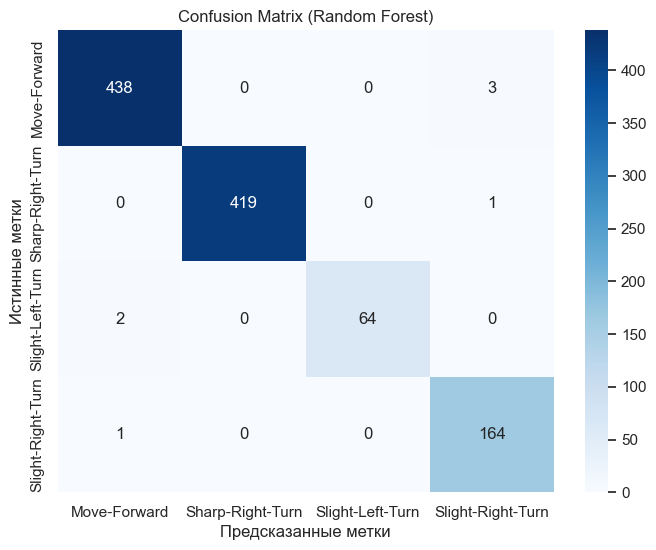

In [14]:
y_pred_test = rf.predict(X_test)
cm = confusion_matrix(y_test, y_pred_test)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.ylabel("Истинные метки")
plt.xlabel("Предсказанные метки")
plt.title("Confusion Matrix (Random Forest)")
plt.show()